<a href="https://colab.research.google.com/github/JuanZapa7a/ApredizajeAutomatico/blob/main/Detecting%20Weld%20Defects%20with%20YOLOv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
**From OneDrive**

---

In [1]:
# import requests

# # Enlace de descarga directa
# url = "https://upct-my.sharepoint.com/:u:/g/personal/juan_zapata_upct_es/ESVaFuII1gBMtXrvtmfidIMBvUbFrlsdzhfhoigXJgqwRQ?e=7bksMy"

# # Ruta donde se guardará el archivo descargado
# output_file = "WeldDatasetOD.zip"

# # Descargar el archivo
# response = requests.get(url, stream=True)

# if response.status_code == 200:
#     with open(output_file, 'wb') as f:
#         f.write(response.content)
#     print(f"Archivo descargado y guardado en {output_file}")
# else:
#     print("Error al descargar el archivo, código de estado:", response.status_code)


---
**From Local**

---

In [2]:
from google.colab import files
uploaded = files.upload()


Saving WeldDataset.zip to WeldDataset.zip


---
**Zip file?**

---

In [3]:
!file WeldDataset.zip

WeldDataset.zip: Zip archive data, at least v1.0 to extract, compression method=store


In [4]:
#!file WeldDatasetOD.zip

In [5]:
!rm -rf datasets
!unzip -q  WeldDataset.zip -d datasets

In [6]:
# !rm -rf datasets
# !unzip -q archivoOD.zip -d datasets

---
**List dataset directories**

---

In [7]:
!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (751 kB/s)
Selecting previously unselected package tree.
(Reading database ... 123594 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [8]:
!tree -L 2  datasets/WeldDataset

datasets/WeldDataset
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── valid
    ├── images
    └── labels

9 directories, 0 files



---
**change to a directory tree compatible**

---


In [9]:
# Crear las carpetas 'train', 'test', 'val' dentro de 'images' y 'labels'
!mkdir -p datasets/WeldDataset/images/train
!mkdir -p datasets/WeldDataset/images/test
!mkdir -p datasets/WeldDataset/images/val

!mkdir -p datasets/WeldDataset/labels/train
!mkdir -p datasets/WeldDataset/labels/test
!mkdir -p datasets/WeldDataset/labels/val

# Mover las imágenes a sus nuevas carpetas
!mv datasets/WeldDataset/train/images/* datasets/WeldDataset/images/train/
!mv datasets/WeldDataset/test/images/* datasets/WeldDataset/images/test/
!mv datasets/WeldDataset/valid/images/* datasets/WeldDataset/images/val/

# Mover las etiquetas a sus nuevas carpetas
!mv datasets/WeldDataset/train/labels/* datasets/WeldDataset/labels/train/
!mv datasets/WeldDataset/test/labels/* datasets/WeldDataset/labels/test/
!mv datasets/WeldDataset/valid/labels/* datasets/WeldDataset/labels/val/

# (Opcional) Eliminar las carpetas vacías
!rm -r datasets/WeldDataset/train/images
!rm -r datasets/WeldDataset/test/images
!rm -r datasets/WeldDataset/valid/images

!rm -r datasets/WeldDataset/train/labels
!rm -r datasets/WeldDataset/test/labels
!rm -r datasets/WeldDataset/valid/labels

!rm -r datasets/WeldDataset/train/
!rm -r datasets/WeldDataset/test/
!rm -r datasets/WeldDataset/valid/


---
**Display some images and annotations**

---

In [10]:
import os

# Ruta al directorio que contiene los archivos de etiquetas
label_dir = 'datasets/WeldDataset/labels/train'

# Crear un conjunto para almacenar las clases únicas
unique_classes = set()

# Iterar sobre todos los archivos en el directorio de etiquetas
for label_file in os.listdir(label_dir):
    if label_file.endswith('.txt'):
        with open(os.path.join(label_dir, label_file), 'r') as f:
            for line in f:
                # Extraer el identificador de clase (el primer número en cada línea)
                class_id = int(line.split()[0])
                # Añadirlo al conjunto de clases únicas
                unique_classes.add(class_id)

# Contar cuántas clases hay
num_classes = len(unique_classes)
print(f'Número de clases únicas: {num_classes}')
print(f'Clases encontradas: {sorted(unique_classes)}')


Número de clases únicas: 5
Clases encontradas: [0, 1, 2, 3, 4]


In [11]:
!pip install -q matplotlib opencv-python

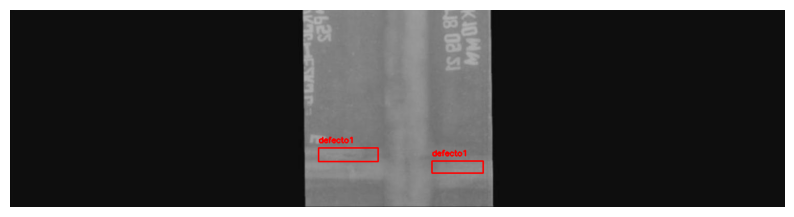

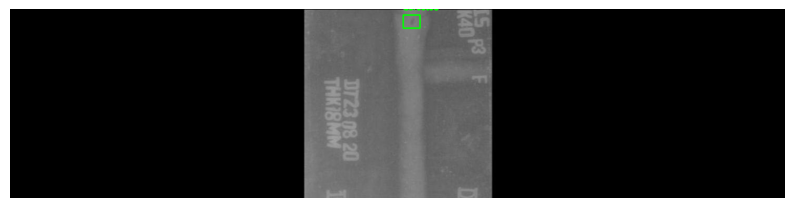

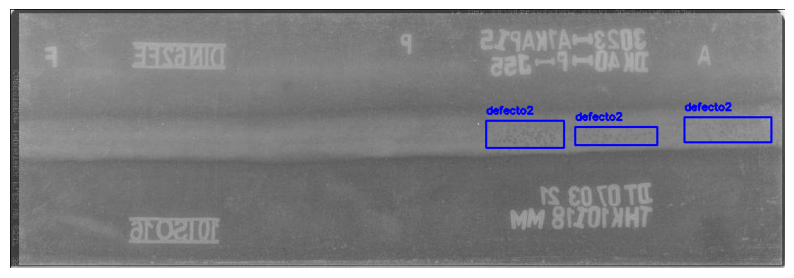

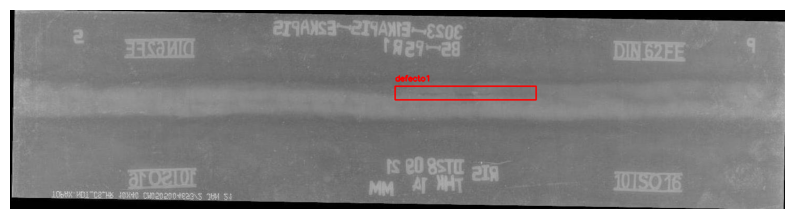

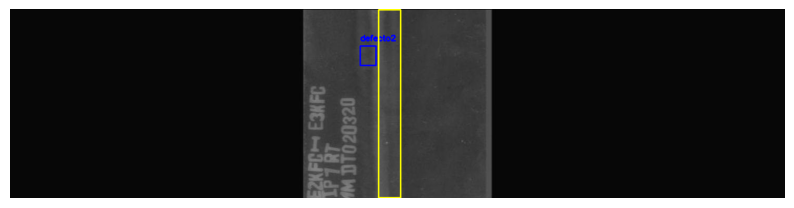

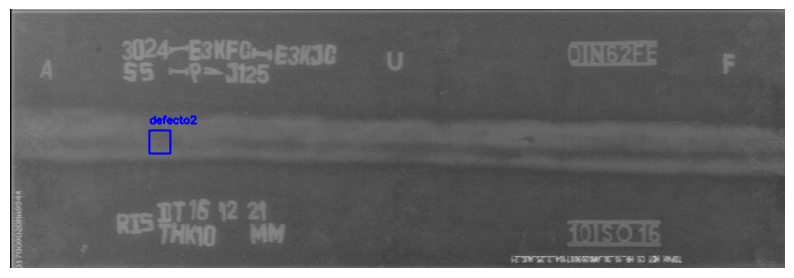

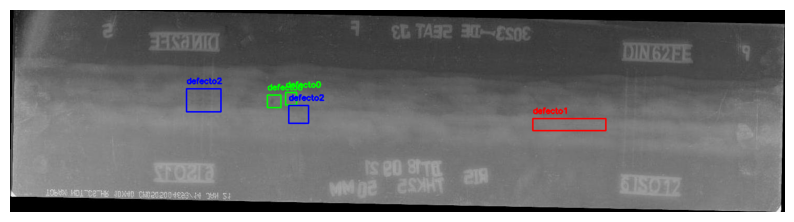

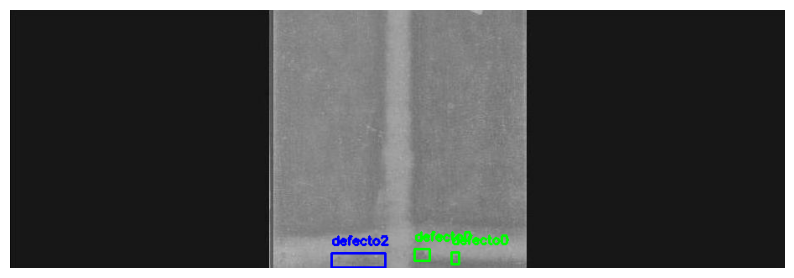

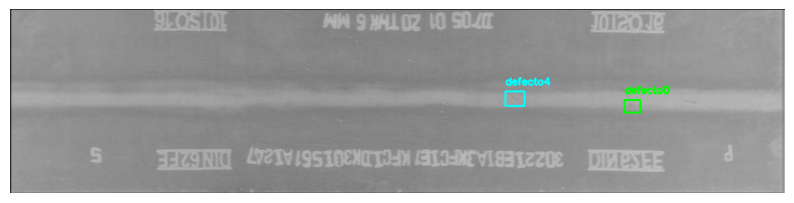

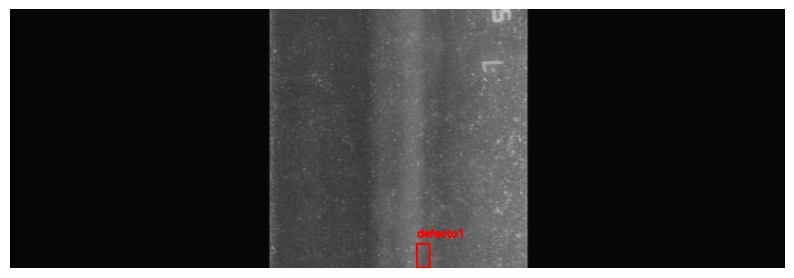

In [12]:
import os
import cv2
import matplotlib.pyplot as plt

# Configura las rutas
image_dir = 'datasets/WeldDataset/images/train'  # Ruta a las imágenes
label_dir = 'datasets/WeldDataset/labels/train'  # Ruta a las etiquetas

# Configura los colores y clases
class_names = ['defecto0', 'defecto1', 'defecto2', 'defecto3', 'defecto4' ]  # Agrega más clases si es necesario
colors = [(0, 255, 0), (255, 0, 0), (0, 0 , 255), (255, 255, 0), (0, 255, 255) ]  # Agrega colores correspondientes a las clases

# Función para visualizar las imágenes con etiquetas
def visualize_images_with_labels(image_dir, label_dir, class_names, colors, num_images=5):
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    for i, image_file in enumerate(image_files[:num_images]):
        # Leer la imagen
        img_path = os.path.join(image_dir, image_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR (OpenCV) a RGB (matplotlib)

        # Leer el archivo de etiquetas correspondiente
        label_path = os.path.join(label_dir, image_file.replace('.jpg', '.txt'))
        with open(label_path, 'r') as f:
            labels = f.readlines()

        # Dibujar las etiquetas en la imagen
        h, w, _ = img.shape
        for label in labels:
            class_id, x_center, y_center, width, height = map(float, label.strip().split())
            x_center, y_center, width, height = x_center * w, y_center * h, width * w, height * h

            # Convertir a coordenadas de esquina (xmin, ymin) y (xmax, ymax)
            xmin = int(x_center - width / 2)
            ymin = int(y_center - height / 2)
            xmax = int(x_center + width / 2)
            ymax = int(y_center + height / 2)

            # Asegúrate de que class_id esté dentro del rango válido
            if int(class_id) < len(colors):
                # Dibujar el rectángulo y el nombre de la clase
                cv2.rectangle(img, (xmin, ymin), (xmax, ymax), colors[int(class_id)], 2)
                cv2.putText(img, class_names[int(class_id)], (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[int(class_id)], 2)
            else:
                print(f"Warning: Class ID {int(class_id)} out of range for image {image_file}. Skipping this label.")

        # Mostrar la imagen
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# Visualiza las primeras 5 imágenes con etiquetas
visualize_images_with_labels(image_dir, label_dir, class_names, colors, num_images=10)

---
**obtener la distribución de clases**

---

In [ ]:
import os
import matplotlib.pyplot as plt

# Función para contar anotaciones por clase en una carpeta
def count_class_instances(label_dir):
    class_counts = [0] * 5  # Asumiendo que tienes 5 clases (0 a 4)

    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(label_dir, label_file), 'r') as file:
                lines = file.readlines()
                for line in lines:
                    class_id = int(line.split()[0])
                    class_counts[class_id] += 1
    return class_counts

# Rutas a las carpetas de etiquetas
train_label_dir = 'datasets/WeldDataset/labels/train'
val_label_dir = 'datasets/WeldDataset/labels/val'
test_label_dir = 'datasets/WeldDataset/labels/test'

# Obtener la distribución de clases en cada conjunto
train_class_counts = count_class_instances(train_label_dir)
val_class_counts = count_class_instances(val_label_dir)
test_class_counts = count_class_instances(test_label_dir)

# Nombres de las clases
class_names = ['defecto0', 'defecto1', 'defecto2', 'defecto3', 'defecto4']

# Crear subplots para visualizar cada conjunto
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Gráfico de distribución en el conjunto de entrenamiento
ax[0].bar(class_names, train_class_counts, color='skyblue')
ax[0].set_title('Distribución en Train')
ax[0].set_xlabel('Clases')
ax[0].set_ylabel('Número de instancias')

# Gráfico de distribución en el conjunto de validación
ax[1].bar(class_names, val_class_counts, color='lightgreen')
ax[1].set_title('Distribución en Val')
ax[1].set_xlabel('Clases')

# Gráfico de distribución en el conjunto de prueba
ax[2].bar(class_names, test_class_counts, color='salmon')
ax[2].set_title('Distribución en Test')
ax[2].set_xlabel('Clases')

# Mostrar los gráficos
plt.tight_layout()
plt.show()


---
**crear el archivo weld_data.yaml**

___

In [13]:
# Código para crear el archivo weld_data.yaml
yaml_content = """
train: WeldDataset/images/train
val: WeldDataset/images/val
test: WeldDataset/images/test

names:
  0: 'defecto0'
  1: 'defecto1'
  2: 'defecto2'
  3: 'defecto3'
  4: 'defecto4'
"""

# Crear el archivo weld_data.yaml
with open("weld_data.yaml", "w") as file:
    file.write(yaml_content)

print("Archivo weld_data.yaml creado con éxito.")


Archivo weld_data.yaml creado con éxito.


---
**Configurar el entorno de trabajo**

---

In [14]:
!pip install -q ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 32.2 MB/s eta 0:00:00


---
**Entrenar el modelo YOLOv8**

---

In [ ]:
from ultralytics import YOLO

# Cargar el modelo YOLOv8 para detección
model = YOLO('yolov8n.pt')  # Puedes cambiar 'n' por 's', 'm', 'l', o 'x' según el tamaño del modelo

# Entrenar el modelo
model.train(data='weld_data.yaml',  # Ruta al archivo YAML de configuración de datos
            epochs=50,  # Número de épocas
            imgsz=640,  # Tamaño de la imagen
            batch=16,  # Tamaño del batch
            name='weld_detection')  # Nombre del experimento


100%|██████████| 6.25M/6.25M [00:00<00:00, 128MB/s]


Ultralytics YOLOv8.2.75 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=weld_data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=weld_detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

100%|██████████| 755k/755k [00:00<00:00, 33.6MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/datasets/WeldDataset/labels/train... 8688 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8688/8688 [00:07<00:00, 1157.59it/s]


train: New cache created: /content/datasets/WeldDataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/WeldDataset/labels/val... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 595.48it/s]


val: New cache created: /content/datasets/WeldDataset/labels/val.cache
Plotting labels to runs/detect/weld_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/weld_detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.61G      2.833      3.936      1.744         51        640: 100%|██████████| 543/543 [03:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        300        601       0.18      0.194      0.128     0.0487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.29G      2.459      2.496      1.566         79        640: 100%|██████████| 543/543 [02:53<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.01it/s]

                   all        300        601      0.336      0.305      0.267       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.29G      2.365      2.187      1.515         72        640: 100%|██████████| 543/543 [02:51<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.95it/s]

                   all        300        601      0.386      0.284      0.248      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.29G      2.252      2.027      1.464         56        640: 100%|██████████| 543/543 [02:49<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.73it/s]

                   all        300        601      0.443      0.362      0.367      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.29G      2.165       1.89      1.413         71        640: 100%|██████████| 543/543 [02:48<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.97it/s]

                   all        300        601      0.452      0.474      0.437      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.26G      2.056      1.748      1.353         69        640: 100%|██████████| 543/543 [02:47<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]

                   all        300        601      0.536      0.481      0.514      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.26G      1.976       1.64      1.313         58        640: 100%|██████████| 543/543 [02:46<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


                   all        300        601      0.625      0.514      0.559      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.25G      1.897      1.552      1.271         67        640: 100%|██████████| 543/543 [02:48<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.12it/s]

                   all        300        601      0.688      0.592      0.652      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.26G      1.835      1.453       1.24         60        640: 100%|██████████| 543/543 [02:46<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300        601        0.7      0.601      0.661      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.26G      1.764      1.374      1.207         61        640: 100%|██████████| 543/543 [02:45<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.47it/s]

                   all        300        601      0.703      0.643      0.686      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.28G      1.718      1.321      1.185         61        640: 100%|██████████| 543/543 [02:54<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.26it/s]

                   all        300        601       0.78      0.671      0.765      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.25G       1.67      1.255      1.158         60        640: 100%|██████████| 543/543 [02:48<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.07it/s]

                   all        300        601      0.813      0.709      0.787      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.26G      1.627      1.207      1.136         71        640: 100%|██████████| 543/543 [02:45<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]

                   all        300        601      0.777      0.738      0.804      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.28G      1.587      1.149      1.115         61        640: 100%|██████████| 543/543 [02:46<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

                   all        300        601      0.862      0.773      0.831      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.29G       1.54        1.1      1.097         57        640: 100%|██████████| 543/543 [02:46<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.03it/s]

                   all        300        601      0.796      0.756       0.84      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.29G      1.511      1.076      1.081         66        640: 100%|██████████| 543/543 [02:48<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.98it/s]

                   all        300        601      0.855      0.761      0.829      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.26G      1.468      1.029      1.066         66        640: 100%|██████████| 543/543 [02:49<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.74it/s]

                   all        300        601      0.901      0.767      0.861      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.24G      1.455       1.01       1.06         58        640: 100%|██████████| 543/543 [02:46<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]

                   all        300        601      0.877      0.796      0.864      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.24G      1.418      0.982      1.043         52        640: 100%|██████████| 543/543 [02:44<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]


                   all        300        601      0.896      0.834      0.888      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.28G       1.38     0.9455      1.027         70        640: 100%|██████████| 543/543 [02:46<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.84it/s]

                   all        300        601      0.911       0.81      0.891      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.28G       1.37     0.9284      1.023         76        640: 100%|██████████| 543/543 [02:47<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.06it/s]

                   all        300        601      0.949      0.846      0.917      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.29G      1.349     0.9119       1.02         60        640: 100%|██████████| 543/543 [02:44<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


                   all        300        601      0.908      0.866      0.912      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.29G      1.318     0.8866      1.002         60        640: 100%|██████████| 543/543 [02:42<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.40it/s]

                   all        300        601      0.917      0.865      0.913        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.26G      1.301     0.8682     0.9996         51        640: 100%|██████████| 543/543 [02:45<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.99it/s]

                   all        300        601      0.938      0.855      0.921      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.24G       1.28     0.8506     0.9915         57        640: 100%|██████████| 543/543 [02:48<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]

                   all        300        601      0.928      0.903      0.935      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.26G      1.258     0.8308     0.9817         78        640: 100%|██████████| 543/543 [02:45<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


                   all        300        601       0.95      0.883      0.939      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.28G      1.248     0.8168     0.9785         62        640: 100%|██████████| 543/543 [02:45<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.25it/s]

                   all        300        601      0.954      0.857      0.939       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.29G      1.225     0.8012       0.97         57        640: 100%|██████████| 543/543 [02:50<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.02it/s]

                   all        300        601      0.929       0.91      0.949      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.29G       1.21     0.7857     0.9646         65        640: 100%|██████████| 543/543 [02:47<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.73it/s]

                   all        300        601       0.94      0.887      0.945      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.26G        1.2     0.7771     0.9608         88        640: 100%|██████████| 543/543 [02:48<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.17it/s]

                   all        300        601      0.944      0.885      0.946       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.24G      1.172     0.7577     0.9538         50        640: 100%|██████████| 543/543 [02:50<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.92it/s]

                   all        300        601      0.905      0.888      0.937      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.29G      1.154     0.7488     0.9492         58        640: 100%|██████████| 543/543 [02:47<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300        601      0.942      0.892      0.943      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.26G      1.143     0.7293     0.9416         62        640: 100%|██████████| 543/543 [02:45<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]

                   all        300        601      0.938      0.905      0.956      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.29G      1.145     0.7303     0.9413         70        640:  43%|████▎     | 233/543 [01:11<01:19,  3.91it/s]